In [3]:
#### GRI GENERATOR

In [4]:
### EXTRACTING GRI SOURCE DATA FROM GENERAL MS EXCEL SOURCE
def get_gri_data_from_excel():
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd
    from datetime import date
    ### Source xlsx file attributes:
    path_gri_data_xlsx = 'Data_Files/Source_Files/mri_data.xlsx'
    tab_gri_model = 'Model 01'  
    ### Reading Model information from Source model sheet:
    df_model_raw = pd.read_excel(path_gri_data_xlsx, sheet_name = tab_gri_model, header = 1, usecols = [0, 1, 2, 3, 4, 5, 6])
    ### Group border rows deleting:
    df_model_raw = df_model_raw[df_model_raw['Asset Group'] != df_model_raw['Asset Code']]   
    ### Dividing list on asset part and MRI weights part:
    df_model_asset = df_model_raw[df_model_raw['Asset Group'] != 'MRI'] ### Asset part
    df_model_asset.reset_index(drop = True, inplace = True)
    df_model_gri = df_model_raw[df_model_raw['Asset Group'] == 'MRI'] ### MRI part
    df_model_gri.reset_index(drop = True, inplace = True) 
    ### Aggregating data from the source xlsx file to pd.DataFrame:
    arr_tab_data = []
    for iter_index, iter_row in df_model_asset.iterrows():
        iter_tab = iter_row['Asset Tab Name']
        iter_asset = iter_row['Asset Code']
        ser_iter_tab = pd.read_excel(path_gri_data_xlsx, sheet_name = iter_tab, header = 0, index_col = 0, squeeze = True)
        ser_iter_tab.name = iter_asset
        arr_tab_data.append(ser_iter_tab)
    df_source_data = pd.concat(arr_tab_data, axis = 1, join = 'outer')  
    df_source_data.index.name = 'Date'
    df_source_data = df_source_data.astype('float64')

    return [df_model_asset, df_model_gri, df_source_data]
    
### EXTRACTING SOURCE DATA FROM MS EXCEL FILES AND SAVING TO HDF FILES SCRIPT
### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd
from datetime import date
### Global parameters declaring:
date_first = date(1990, 1, 1)
date_last = date(2018, 12, 31)
### Declaring constants:
path_gri_data_hdf = 'Data_Files/Source_Files/gri_data.h5'
model_asset_key = 'model_asset_key'
model_gri_key = 'model_gri_key'
source_data_key = 'source_data_key'
### Data extracting:
[df_model_asset, df_model_gri, df_source_data] = get_gri_data_from_excel()
### closing files that have been previously opened:
import tables
tables.file._open_files.close_all()
### Saving data to hdf5 table formatted files:
df_model_asset.to_hdf(path_gri_data_hdf, model_asset_key, mode = 'w', format = 'fixed')
df_model_gri.to_hdf(path_gri_data_hdf, model_gri_key, mode = 'a', format = 'fixed')
df_source_data.to_hdf(path_gri_data_hdf, source_data_key, mode = 'a', format = 'fixed')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Asset Group', 'Asset Group Description', 'Asset Code', 'Asset Tab Name', 'Asset Desc', 'Processing Routine']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [5]:
### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd
from datetime import date
### Declaring constants:
path_gri_data_hdf = 'Data_Files/Source_Files/gri_data.h5'
model_asset_key = 'model_asset_key'
model_gri_key = 'model_gri_key'
source_data_key = 'source_data_key'

df_model_asset = pd.read_hdf(path_gri_data_hdf, model_asset_key)
df_model_gri = pd.read_hdf(path_gri_data_hdf, model_gri_key)
df_source_data = pd.read_hdf(path_gri_data_hdf, source_data_key)

In [6]:
def get_rolling_z_score(ser_source, min_wnd, max_wnd, winsor_bottom, winsor_top):
    ### Importing standard modules:    
    import numpy as np
    import pandas as pd
    
    ### Initializing z-score vector:
    ser_asset_z_score = pd.Series(np.NaN, index = ser_source.index)
    ser_asset_z_score = ser_asset_z_score.astype('float64')
    if (ser_source.count() > 0):
        ### Initialising index conditions:
        asset_start_index = ser_source.first_valid_index() + pd.offsets.BusinessDay(min_wnd - 1)  
        iter_date_index = ser_source.index[-1]
        ### Checking for at list min_wnd elements of rolling window are not np.NaN:
        if (iter_date_index >= asset_start_index):          
            ### Isolating rolling window for particular data vector element:
            iter_start_index = iter_date_index - pd.offsets.BusinessDay(max_wnd)
            ser_iter_source = ser_source.loc[iter_start_index : iter_date_index]        
            ser_iter_z_score = (ser_iter_source - ser_iter_source.mean()) / ser_iter_source.std()            
            ### Winsorization process:
            bool_to_winsor = True            
            while (bool_to_winsor): 
                ### Value based winsorization:                
                ser_iter_z_score.clip(lower = winsor_bottom, upper = winsor_top, inplace = True)
                ### Recalculating of z scores:
                ser_iter_z_score = (ser_iter_z_score - ser_iter_z_score.mean()) / ser_iter_z_score.std()
                ### Checking for boundaries:
                if (ser_iter_z_score[(ser_iter_z_score <= (winsor_bottom - 0.01)) | (ser_iter_z_score >= (winsor_top + 0.01))].count() == 0):
                    bool_to_winsor = False
            ### Filling z vector part after the winsorizing (if needed):
            ser_asset_z_score.loc[iter_start_index : iter_date_index] = ser_iter_z_score.values
    return ser_asset_z_score

In [5]:
    ### TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING
    ### Importing standard modules and date-special modules:    
    import numpy as np
    import pandas as pd
    from datetime import date    
    ### Declaring constants:
    date_start = date(1993, 12, 31)    
    path_gri_data_hdf = 'Data_Files/Source_Files/gri_data.h5'
    model_asset_key = 'model_asset_key'
    model_gri_key = 'model_gri_key'
    source_data_key = 'source_data_key'
    ### Limitations for rolling windows for z-score calculating:
    asset_window_min = 252
    asset_window_max = 252 * 100
    ### Limitations for z-score winsorizing:
    arr_winsor_boundary = [-4, 4]
    asset_code = 'iv_rvx'
    ser_test = get_rolling_z_score(np.log(df_source_data[asset_code]), asset_window_min, asset_window_max, arr_winsor_boundary[0], arr_winsor_boundary[1])

In [7]:
def get_gri_value(iter_date):
    ### Importing standard modules and date-special modules:    
    import numpy as np
    import pandas as pd
    from datetime import date    
    ### Declaring constants:
    date_first = date(1990, 1, 1)    
    date_start = date(1993, 12, 31)    
    path_gri_data_hdf = 'Data_Files/Source_Files/gri_data.h5'
    model_asset_key = 'model_asset_key'
    model_gri_key = 'model_gri_key'
    source_data_key = 'source_data_key'
    ### Limitations for rolling windows for z-score calculating:
    asset_window_min = 252
    asset_window_max = 252 * 100
    mri_window_max = 260 * 10
    ### Limitations for z-score winsorizing:
    winsor_bottom = -4
    winsor_top = 4    
    ### Limitations for moving average for GRI calculation:
    ma_max_wnd = 5    
    ### Extracting model data from hdf5 file:
    df_model_asset = pd.read_hdf(path_gri_data_hdf, model_asset_key)
    df_model_gri = pd.read_hdf(path_gri_data_hdf, model_gri_key)
    df_source_data = pd.read_hdf(path_gri_data_hdf, source_data_key).loc[ : iter_date]
    df_source_data.fillna(method = 'ffill', inplace = True)
    index_selected = pd.date_range(date_first, iter_date, freq = 'B')
    df_selected_data = df_source_data.reindex(index_selected, method = 'ffill')    
    ### Base assets determination (resorting by earliest value):
    df_model_asset['Asset Date'] = date(1900, 1, 1)
    for (iter_index, asset_code) in df_model_asset['Asset Code'].iteritems():
        df_model_asset.loc[iter_index, 'Asset Date'] = df_selected_data[asset_code].dropna().index.min() 
    df_model_asset.sort_values(['Asset Group', 'Asset Date'], inplace = True)
    df_model_asset = df_model_asset.reset_index(drop = True)    
    ### Initialising loop visibility variables:          
    dict_group_container = {} ### Group vectors collection for gri mean vector calculation   
    ### Standartizing loop on group level:
    for asset_group_name, df_asset_group in df_model_asset.groupby('Asset Group'):
        ### Initialising group visibility variables:
        bool_base_asset = True
        dict_asset_container = {} ### Asset vectors collection for group mean matrix calculation
        ### Standartizing cycle on asset level with the group:
        for (asset_index, asset_code) in df_asset_group['Asset Code'].iteritems():
            ### Assignment of base asset data set:
            if (bool_base_asset):
                bool_base_asset = False
                ### Performing z scoring for base asset:
                ser_base_source = np.log(df_selected_data[asset_code][: iter_date])
                ser_base_z_score = get_rolling_z_score(ser_base_source, 
                                                       asset_window_min, asset_window_max,
                                                       winsor_bottom, winsor_top)
                ### Calculating ethalon filled quantity before date_start:
                int_base_filled = ser_base_source[ : date_start].count()
                ### Adding result to dictionary:
                dict_asset_container[asset_code] = ser_base_z_score
            ### Normalization of other asset's data sets:                
            else:
                ### Performing z scoring for asset:        
                ser_asset_source = np.log(df_selected_data[asset_code][: iter_date])                
                ser_asset_z_score = get_rolling_z_score(ser_asset_source, 
                                                        asset_window_min, asset_window_max,
                                                        winsor_bottom, winsor_top)
                ### Calculating asset filled quantity:                
                int_asset_filled = ser_asset_source[ : date_start].count()          
                ### Standartizing asset if it does not have enough initial values:
                if (int_asset_filled < int_base_filled * 2 / 3):
                    ### RenormaLizing asset z vector with base z vector data:
                    if (ser_asset_z_score.first_valid_index() != None):                
                        index_asset_start = ser_asset_z_score.first_valid_index() + pd.offsets.BusinessDay(asset_window_min - 1)
                        ser_base_z_part = ser_base_z_score.loc[index_asset_start - pd.offsets.BusinessDay(asset_window_min - 1) : iter_date]    
                        ser_asset_z_score = ser_asset_z_score * ser_base_z_part.std() + ser_base_z_part.mean()
                ### Adding result to dictionary:  
                dict_asset_container[asset_code] = ser_asset_z_score   
        ### Calculating z vector for group:
        ser_group_mean = pd.concat(dict_asset_container, axis = 0, names = ['Asset Code', 'Date'], copy = False)
        ser_group_mean = ser_group_mean.groupby('Date').mean()    
        ser_group_mean_z = (ser_group_mean - ser_group_mean.mean()) / ser_group_mean.std()  
        dict_group_container[asset_group_name] = ser_group_mean_z
    ### Model groups mean calculation:    
    ser_model_mean = pd.concat(dict_group_container, axis = 0, names = ['Group', 'Date'], copy = False)
    ser_model_mean = ser_model_mean.groupby(['Date']).mean()  
    ### GRI z-scoring:
    ser_gri_z_score = pd.Series(np.NaN, index = ser_model_mean.index)
    if (iter_date >= pd.Timestamp(date_start)):
        ser_iter_mri = ser_model_mean.loc[iter_date - pd.offsets.BusinessDay(mri_window_max) : iter_date]
        ser_iter_z_score = (ser_iter_mri - ser_iter_mri.mean()) / ser_iter_mri.std()
        ### Winsorization process:
        bool_to_winsor = True            
        while (bool_to_winsor):       
            ### Value based winsorization:
            ser_iter_z_score.clip(lower = winsor_bottom, upper = winsor_top, inplace = True)
            ### Recalculating of z scores:
            ser_iter_z_score = (ser_iter_z_score - ser_iter_z_score.mean()) / ser_iter_z_score.std()                
            ### Checking for boundaries:
            if (ser_iter_z_score[(ser_iter_z_score <= (winsor_bottom - 0.01)) | (ser_iter_z_score >= (winsor_top + 0.01))].count() == 0):                    
                bool_to_winsor = False    
        ser_gri_z_score.loc[iter_date - pd.offsets.BusinessDay(mri_window_max) : iter_date] = ser_iter_z_score.values
    ### Calculating z matrix for MRI with winsorization:       
    ser_gri_z_ma = ser_gri_z_score.copy()
    for iter_shift in np.arange(1, ma_max_wnd):
        ser_gri_z_ma = ser_gri_z_ma + ser_gri_z_score.shift(iter_shift)
    ser_gri_z_ma = ser_gri_z_ma / ma_max_wnd
    
    return ser_gri_z_ma

In [8]:
### ALL CELL ADDED FOR BETA PERCENTILE FACTORS CALCULATION

### DEFINING EXPONENTIAL WEIGHTS GENERATOR
def get_exp_weights(window_years = 5, halflife_months = 3):
    ### Importing standard modules:    
    import numpy as np
    import pandas as pd
    import math     
    ### Defining constants:
    num_year_work_days = 260
    num_year_months = 12
    ### Array of regressioon window day numbers descending:
    arr_weight_days = np.arange(num_year_work_days * window_years, 0, -1) - 1
    ### Creating weights series:
    num_period_factor = math.exp(math.log(0.5) / round((num_year_work_days / num_year_months * halflife_months)))
    arr_weights = np.exp(math.log(num_period_factor) * arr_weight_days)
    ser_weights = pd.Series(arr_weights)        
    ser_weights.name = 'Weight'
    
    return ser_weights

### DEFINING WEIGHTS TO SERIES BINDER
def bind_exp_weights(ser_returns, weighting_kind = 'equal', window_years = 5, halflife_months = 3, ser_condition = pd.Series(np.NaN)):
    ### Importing standard modules:    
    import numpy as np
    import pandas as pd
    ### Creating weights series:
    if (weighting_kind == 'equal'):
        ser_weights = pd.Series(1, index = ser_returns.index)
    if (weighting_kind == 'expo'):       
        ser_weights = get_exp_weights(window_years, halflife_months)[- ser_returns.size : ]
        ser_weights.index = ser_returns.index
    if (weighting_kind == 'expo_cond'):
        ser_condition = abs(ser_condition - ser_condition.iloc[-1])
        ser_condition = ser_condition.sort_values(ascending = False)
        ser_weights = get_exp_weights(window_years, halflife_months)[- ser_returns.size : ]
        ser_weights = pd.Series(ser_weights.values, ser_condition.index)
        ser_weights.sort_index(inplace = True)
        ser_weights.name = 'Weight'
        
    return ser_weights

### DEFINING WEIGHTED AVERAGE CALCULATOR
def get_average_value(ser_returns, ser_weights):
    ### Importing standard modules:    
    import numpy as np
    import pandas as pd
    ### Rolling average calculating:
    average_result = np.NaN  
    ser_returns = ser_returns.dropna()
    index_rolling = ser_returns.index.intersection(ser_weights.index)           
    ### Exponential volatility calculating:
    average_x = ser_returns[index_rolling]
    average_w = ser_weights[index_rolling]                    
    average_result = average_x.dot(average_w) / sum(average_w)        
        
    return average_result  

In [19]:
### LOOPER FOR GRI
### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd
from datetime import date
import math  
### Global parameters declaring:
date_start = date(1993, 12, 31)  
date_last = date(2018, 12, 31)
date_range_test = pd.date_range(date_start, date_last, freq = 'B')
#date_test = date(2013, 6, 20)
#date_range_test = pd.date_range(date_test, date_test, freq = 'B')
### Percentile and signs constants declaring:
percentile_years = 10
average_years = 5
halflife_months = 12
num_year_work_days = 260
### General looping:
dict_gri_vector = {}
iter_counter = 0
for iter_date in date_range_test:
    iter_counter = iter_counter + 1
    dict_gri_vector[iter_date] = get_gri_value(iter_date)
    if ((iter_counter // 1000) == (iter_counter / 1000)):
        print('Vintage progress printout', iter_counter, '/', iter_date)
ser_gri_full = pd.concat(dict_gri_vector)
ser_gri_released = pd.Series(np.NaN, index = ser_gri_full.index.get_level_values(0).unique())
### Percentile series dummies:
ser_level_perc_gri = pd.Series(np.NaN, index = ser_gri_full.index.get_level_values(0).unique()) ### ADDED FOR BETA PECENTILE FACTORS CALCULATION
ser_momentum_perc_gri = pd.Series(np.NaN, index = ser_gri_full.index.get_level_values(0).unique()) ### ADDED FOR BETA PECENTILE FACTORS CALCULATION
#ser_momentum_gri = pd.Series(np.NaN, index = ser_gri_full.index.get_level_values(0).unique()) ### FOR TESTING PURPOSES
iter_counter = 0
for iter_date in ser_gri_released.index:
    iter_counter = iter_counter + 1
    if ((iter_counter // 1000) == (iter_counter / 1000)):
        print('Vectors progress printout', iter_counter, '/', iter_date)    
    ### Selecting GRI vintage column for percentiles calculation:
    index_iter_date = pd.date_range(end = iter_date, periods = percentile_years * num_year_work_days, freq = 'B') ### ADDED FOR BETA FACTORS CALCULATION
    index_iter_date_mean = pd.date_range(end = iter_date, periods = average_years * num_year_work_days, freq = 'B') ### ADDED FOR BETA FACTORS CALCULATION            
    ser_iter_vintage = ser_gri_full[iter_date] ### ADDED FOR BETA FACTORS CALCULATION
    ser_iter_vintage = ser_iter_vintage[index_iter_date] ### ADDED FOR BETA FACTORS CALCULATION    
#    ser_gri_released[iter_date] = ser_gri_full.loc[iter_date, iter_date]
    ser_gri_released[iter_date] = ser_iter_vintage.loc[iter_date] ### CHANGED
    ### Level percentile calculating:    
    ser_level_perc_gri[iter_date] = ser_iter_vintage.rank(method = 'average', na_option = 'keep', ascending = True, pct = True).iloc[-1] ### ADDED FOR BETA FACTORS
    ### Daily changes for momentum percentiles receiving:
    ser_iter_vintage = ser_iter_vintage - ser_iter_vintage.shift(1) ### ADDED FOR BETA FACTORS CALCULATION
    ### Weighted average calculating for momentum percentiles:
    ser_iter_vintage_mean = ser_iter_vintage[index_iter_date_mean] ### ADDED FOR BETA FACTORS CALCULATION
    ser_iter_weights = bind_exp_weights(ser_iter_vintage_mean, 'expo', average_years, halflife_months) ### ADDED FOR BETA FACTORS CALCULATION
    ser_iter_vintage_mean = ser_iter_vintage_mean.dropna() ### ADDED FOR BETA FACTORS CALCULATION
    num_iter_average = get_average_value(ser_iter_vintage_mean, ser_iter_weights) ### ADDED FOR BETA FACTORS CALCULATION
    ser_iter_weights = ser_iter_weights / ser_iter_weights.sum() ### ADDED FOR BETA FACTORS CALCULATION
    num_iter_average = num_iter_average * math.sqrt(1 / ((ser_iter_weights * ser_iter_weights).sum())) ### ADDED FOR BETA FACTORS CALCULATION
    ser_iter_vintage[-1] = num_iter_average ### ADDED FOR BETA FACTORS CALCULATION
    ### Momentum percentile calculating:
    ser_momentum_perc_gri[iter_date] = ser_iter_vintage.rank(method = 'average', na_option = 'keep', ascending = True, pct = True).iloc[-1] ### ADDED FOR BETA FACTORS
#    ser_momentum_gri[iter_date] = num_iter_average ### FOR TESTING PURPOSES
ser_gri_released.index.name = 'Date'
ser_gri_released.name = 'GRI_MA5'
ser_level_perc_gri.index.name = 'Date' ### ADDED FOR BETA FACTORS CALCULATION
ser_level_perc_gri.name = 'GRI_Level_Perc' ### ADDED FOR BETA FACTORS CALCULATION
ser_momentum_perc_gri.index.name = 'Date' ### ADDED FOR BETA FACTORS CALCULATION
ser_momentum_perc_gri.name = 'GRI_Momentum_Perc' ### ADDED FOR BETA FACTORS CALCULATION

In [23]:
print('ser_iter_weights min:', ser_iter_weights.min())
print('ser_iter_weights mean:', ser_iter_weights.mean())
print('ser_iter_weights max:', ser_iter_weights.max())
print('ser_iter_weights stdev:', ser_iter_weights.std())
print('ser_iter_weights count:', ser_iter_weights.count())

ser_iter_weights min: 8.611314519576692e-05
ser_iter_weights mean: 0.0007692307692307699
ser_iter_weights max: 0.0027482840812943082
ser_iter_weights stdev: 0.0007072385809436454
ser_iter_weights count: 1300


In [11]:
### RESULTS SAVING
path_gri_index_hdf = 'Data_Files/Source_Files/gri_released_index.h5'
gri_vector_key = 'gri_vector_key'
gri_vintage_key = 'gri_vintage_key'
gri_start_key = 'gri_start_key'
gri_level_perc_key = 'gri_level_perc_key' ### ADDED FOR BETA FACTORS CALCULATION
gri_momentum_perc_key = 'gri_momentum_perc_key' ### ADDED FOR BETA FACTORS CALCULATION
ser_gri_released.to_hdf(path_gri_index_hdf, gri_vector_key, mode = 'w', format = 'fixed')
ser_level_perc_gri.to_hdf(path_gri_index_hdf, gri_level_perc_key, mode = 'a', format = 'fixed') ### ADDED FOR BETA FACTORS CALCULATION
ser_momentum_perc_gri.to_hdf(path_gri_index_hdf, gri_momentum_perc_key, mode = 'a', format = 'fixed') ### ADDED FOR BETA FACTORS CALCULATION
ser_gri_full.index.names = ['Date_Point', 'Date']
ser_gri_full.to_hdf(path_gri_index_hdf, gri_vintage_key, mode = 'a', format = 'fixed')
ser_gri_full.loc[date_start, :].to_hdf(path_gri_index_hdf, gri_start_key, mode = 'a', format = 'fixed')

In [2]:
### TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING TESTING
import numpy as np
import pandas as pd
path_gri_index_hdf = 'Data_Files/Source_Files/gri_released_index.h5'
gri_vector_key = 'gri_vector_key'
gri_level_perc_key = 'gri_level_perc_key' ### ADDED FOR BETA FACTORS CALCULATION
gri_momentum_perc_key = 'gri_momentum_perc_key' ### ADDED FOR BETA FACTORS CALCULATION
ser_gri_released = pd.read_hdf(path_gri_index_hdf, gri_vector_key)
ser_level_perc_gri = pd.read_hdf(path_gri_index_hdf, gri_level_perc_key)
ser_momentum_perc_gri = pd.read_hdf(path_gri_index_hdf, gri_momentum_perc_key)
import matplotlib
ser_gri_released.plot(figsize = (15, 5))

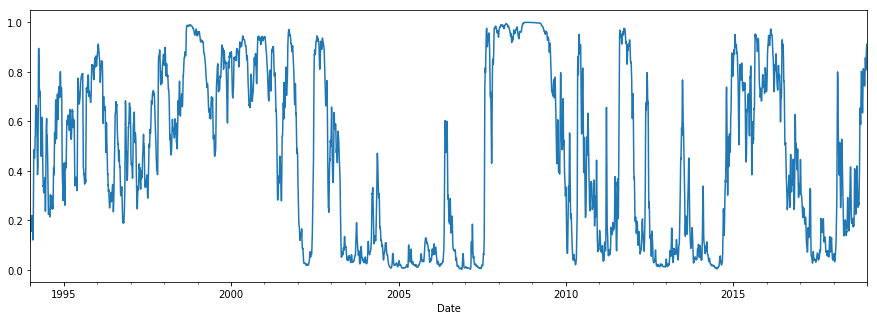

In [6]:
ser_momentum_perc_gri.plot(figsize = (15, 5))